## attention
requires 'all_artist_weekly.csv' and 'all_artist_monthly.csv' generated by `all_plays_in_series.ipynb`

In [57]:
from config_file import data_path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [58]:
import warnings
warnings.filterwarnings('ignore')

In [59]:
df_monthly = pd.read_csv(data_path + 'all_artist_monthly.csv', parse_dates=True)
df_monthly.head()

,timestamp,helper
0,2019-07-31,2206
1,2019-08-31,8981
2,2019-09-30,19700
3,2019-10-31,33395
4,2019-11-30,40245


In [60]:
sarima = SARIMAX(df_monthly['helper'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima.fit(disp=False)
sarima_fit.aic

864.3346987646906

In [61]:
from pmdarima import auto_arima

stepwise_model = auto_arima(df_monthly['helper'], start_p=1, start_q=1,
                            max_p=4, max_q=4, m=12,
                            start_P=0, start_Q=0, seasonal=True,
                            d=1, D=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=860.703, Time=0.04 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=876.007, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=865.734, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=861.704, Time=0.09 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=862.491, Time=0.09 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=862.498, Time=0.10 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=864.335, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=860.316, Time=0.02 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=861.694, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=863.285, Time=0.30 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=860.068, Time=0.04 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=862.053, Time=0.08 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=862.054, Time=0.15 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=863.943, Time=1.26 sec
 ARIMA(1,1,2)(0,1,0)[12]         

In [62]:
grid_search = auto_arima(df_monthly['helper'], start_p=1, start_q=1,
                          max_p=4, max_q=4, m=12,
                          start_P=0, start_Q=0, seasonal=True,
                          d=1, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=876.007, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=890.399, Time=0.06 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=875.970, Time=0.28 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=876.644, Time=0.10 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=886.667, Time=0.07 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=877.546, Time=0.82 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=877.316, Time=0.31 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.48 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=879.542, Time=0.93 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=860.316, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=861.704, Time=0.17 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=863.703, Time=0.75 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=861.694, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=863.285, Time=0.32 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=865.585, Time=1.67 sec
 ARIMA(0,1,1)(

In [63]:
grid_search.aic(), stepwise_model.aic()

(857.6572143472233, 860.0684327737172)

In [64]:
train = df_monthly['helper'][:len(df_monthly)-8]
test = df_monthly['helper'][len(df_monthly)-8:]

sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima.fit(disp=False)
sarima_fit.aic

681.2670047823896

In [69]:
import pickle

with open("test.pkl", "wb") as handle:
    pickle.dump(sarima_fit, handle)

with open("test.pkl", "rb") as handle:
    sarima_fit = pickle.load(handle)

In [65]:
def dummy_model(train, periods: int):
    dummy_pred = np.zeros(periods)
    for i in range(periods):
        if i == 0:
            dummy_pred[i] = train[- (periods) + i:].mean()
        else:
            dummy_pred[i] = train[- (periods) + i:].mean() * (periods - i) / periods + dummy_pred[:i].mean() * i / periods
    return dummy_pred


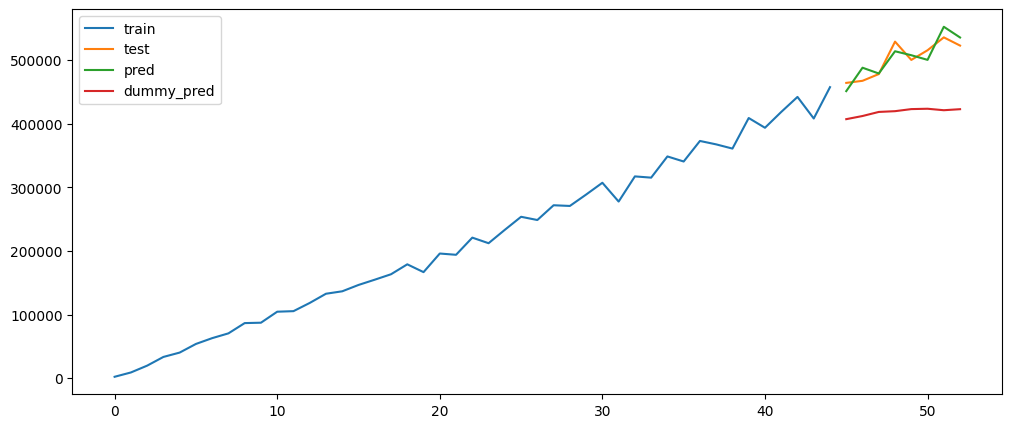

In [70]:

pred = sarima_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
dummy_pred = dummy_model(train, len(test))


plt.figure(figsize=(12, 5))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(pred, label='pred')
plt.plot([None] * len(train) + list(dummy_pred), label='dummy_pred')
plt.legend()
plt.show()

In [67]:
from sklearn.metrics import mean_squared_error
from math import sqrt

sarima_rms = sqrt(mean_squared_error(test, pred))
dummy_rms = sqrt(mean_squared_error(test, dummy_pred))
sarima_rms, dummy_rms

(13893.409847657415, 86150.75978534663)

In [68]:
sum_of_test = test.sum()

sarima_rms / sum_of_test, dummy_rms / sum_of_test

(0.0034613407441968047, 0.02146320725137258)